# SPY Implied Volatility Surface Analysis

---

**Author:** Louison Robert  
**Institution:** Université Paris-Saclay - Master 1 Finance  
**Date:** December 2024  

---

## Abstract

This project presents a comprehensive analysis of the implied volatility surface for SPY (S&P 500 ETF) options. Using market data for three distinct maturities (30, 60, and 90 days), we implement the Black-Scholes model to calculate implied volatilities and construct a complete volatility surface. The analysis reveals key market patterns including the volatility smile, term structure effects, and Greeks sensitivities. These findings have direct applications in options pricing, risk management, and trading strategies.



---

## 1. Introduction

### 1.1 Context and Motivation

The volatility surface is a fundamental tool in modern quantitative finance, providing a three-dimensional representation of implied volatility across different strikes and maturities. Unlike the classical Black-Scholes model which assumes constant volatility, market-observed option prices reveal systematic patterns known as the "volatility smile" and "term structure."

### 1.2 Objectives

This analysis aims to:
- Extract and process real market data for SPY options
- Calculate implied volatilities using numerical methods
- Visualize and interpret the volatility smile across multiple maturities
- Construct an interactive 3D volatility surface
- Analyze option Greeks and their practical implications

### 1.3 Practical Applications

Understanding the volatility surface is essential for:
- **Pricing:** Consistent valuation of options regardless of strike or maturity
- **Risk Management:** Accurate calculation of portfolio sensitivities
- **Arbitrage Detection:** Identification of mispriced options
- **Market Sentiment Analysis:** Interpretation of implied risk perceptions

---

## 2. Data Extraction and Preparation

### 2.1 Data Sources

We utilize Yahoo Finance API (via yfinance) to extract:
- SPY options chain data for multiple expiration dates
- Current SPY price
- Risk-free rate from 10-Year Treasury yields (^TNX)

### 2.2 Maturity Selection

Three target maturities are selected to capture different time horizons:
- **30 days:** Short-term volatility dynamics
- **60 days:** Medium-term market expectations
- **90 days:** Longer-term volatility structure

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Download SPY data
spy = yf.Ticker("SPY")

# Get risk-free rate from 10Y Treasury
treasury_10y = yf.Ticker("^TNX")
treasury_data = treasury_10y.history(period='1d')
r = treasury_data['Close'].iloc[-1] / 100 

# Get available expirations
expirations = spy.options
print(f"Available maturities: {len(expirations)}")
print(expirations[:10])

Available maturities: 32
('2025-12-04', '2025-12-05', '2025-12-08', '2025-12-09', '2025-12-10', '2025-12-11', '2025-12-12', '2025-12-15', '2025-12-16', '2025-12-19')


### 2.3 Selecting Target Maturities

In [2]:
# Select 3 maturities: 30, 60, 90 days
target_days_list = [30, 60, 90]
selected_expirations = {}
today = datetime.now()

for target_days in target_days_list:
    days_diff = []
    for exp in expirations:
        exp_date = datetime.strptime(exp, '%Y-%m-%d')
        days = (exp_date - today).days
        days_diff.append(abs(days - target_days))
    
    closest_idx = days_diff.index(min(days_diff))
    selected_exp = expirations[closest_idx]
    exp_date = datetime.strptime(selected_exp, '%Y-%m-%d')
    actual_days = (exp_date - today).days
    
    selected_expirations[target_days] = {
        'expiration': selected_exp,
        'actual_days': actual_days,
        'T': actual_days / 365
    }
    
    print(f"\n{target_days}-day maturity: {selected_exp} ({actual_days} days)")


30-day maturity: 2026-01-02 (28 days)

60-day maturity: 2026-01-30 (56 days)

90-day maturity: 2026-02-27 (84 days)


### 2.4 Market Parameters

In [3]:
# Current SPY price
current_price = spy.history(period='1d')['Close'].iloc[-1]

print(f"\n{'='*60}")
print(f"SPY Price: ${current_price:.2f}")
print(f"Risk-free rate (10Y T-Note): {r*100:.3f}%")
print(f"{'='*60}")


SPY Price: $684.45
Risk-free rate (10Y T-Note): 4.108%


### 2.5 Data Extraction and Cleaning

For each maturity, we extract call options and apply the following filters:
- Volume > 0 (ensure liquidity)
- Valid last price (no missing data)
- Valid volume data

In [4]:
# Extract data for each maturity
all_calls_data = {}

for target, info in selected_expirations.items():
    opt_chain = spy.option_chain(info['expiration'])
    calls = opt_chain.calls
    
    # Clean data: keep only valid calls
    calls_clean = calls[
        (calls['volume'].notna()) & 
        (calls['volume'] > 0) & 
        (calls['lastPrice'].notna())
    ].copy()
    
    all_calls_data[target] = calls_clean
    print(f"\n{target}-day maturity: {len(calls_clean)} valid calls")

# Overview of the 3 maturities
for target in [30, 60, 90]:
    print(f"\n{'='*60}")
    print(f"CALLS OVERVIEW - {target} days maturity ({selected_expirations[target]['actual_days']} actual days)")
    print(f"Expiration: {selected_expirations[target]['expiration']}")
    print(f"{'='*60}")
    print(all_calls_data[target][['strike', 'lastPrice']].head(10))
    print(f"\nTotal valid calls: {len(all_calls_data[target])}")


30-day maturity: 104 valid calls

60-day maturity: 205 valid calls

90-day maturity: 184 valid calls

CALLS OVERVIEW - 30 days maturity (28 actual days)
Expiration: 2026-01-02
    strike  lastPrice
0    400.0     286.75
3    530.0     153.51
4    535.0     147.60
5    540.0     142.81
6    545.0     140.02
7    550.0     135.10
9    560.0     122.38
10   565.0     106.71
11   570.0     112.90
12   575.0     103.67

Total valid calls: 104

CALLS OVERVIEW - 60 days maturity (56 actual days)
Expiration: 2026-01-30
    strike  lastPrice
0    420.0     265.91
2    450.0     228.21
4    460.0     216.07
6    470.0     207.04
7    475.0     203.45
8    480.0     197.09
9    485.0     192.77
10   490.0     187.15
11   495.0     182.47
12   500.0     185.04

Total valid calls: 205

CALLS OVERVIEW - 90 days maturity (84 actual days)
Expiration: 2026-02-27
    strike  lastPrice
0    420.0     258.54
1    425.0     253.14
2    435.0     256.30
3    450.0     221.00
4    470.0     197.40
5    485.

---

## 3. Methodology: Black-Scholes-Merton and Implied Volatility

### 3.1 Black-Scholes-Merton Assumptions

The Black-Scholes model relies on several simplifying assumptions:

1. **Constant Volatility:** $\sigma$ remains constant over the option's life
2. **Constant Risk-Free Rate:** $r$ is known and constant
3. **Log-Normal Price Distribution:** Stock prices follow geometric Brownian motion: $dS = \mu S dt + \sigma S dW$
4. **European Exercise:** Options can only be exercised at maturity
5. **No Dividends:** The underlying asset pays no dividends during the option's life
6. **Frictionless Markets:** No transaction costs, taxes, or trading restrictions
7. **Continuous Trading:** Markets operate continuously with perfect liquidity
8. **No Arbitrage:** Markets are efficient with no risk-free profit opportunities

### 3.1.1 Black-Scholes Model for European Call Options

The Black-Scholes formula for a European call option is:

$$C = S_0 N(d_1) - K e^{-rT} N(d_2)$$

where:

$$d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

- $S_0$: Current stock price
- $K$: Strike price
- $T$: Time to expiration (years)
- $r$: Risk-free rate
- $\sigma$: Volatility
- $N(\cdot)$: Cumulative standard normal distribution

### 3.2 Implied Volatility Calculation

Implied volatility is the value of $\sigma$ that makes the Black-Scholes theoretical price equal to the market price. While it theoretically reflects the market's expectation of future realized volatility, it also incorporates a volatility risk premium and supply/demand dynamics. We solve this using Brent's method, a robust root-finding algorithm.

### 3.2.1 Brent's Method for Implied Volatility

**Problem:** Find $\sigma$ such that $C_{BS}(\sigma) = C_{market}$

**Why Brent's Method?**
Combines three approaches for optimal balance:
- **Bisection:** Slow but guaranteed convergence
- **Secant method:** Fast but less reliable  
- **Inverse quadratic interpolation:** Very fast when stable

The algorithm automatically switches between methods based on convergence behavior.

**Key Properties:**
- No derivative required (unlike Newton-Raphson)
- Guaranteed convergence if solution exists in bracket [0.001, 10.0]
- Typical convergence: 5-10 iterations
- Robust to initialization and function behavior

In [5]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate Black-Scholes call option price
    
    Parameters:
    S: Current stock price
    K: Strike price
    T: Time to expiration (years)
    r: Risk-free rate
    sigma: Volatility
    
    Returns:
    Call option price
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_volatility(market_price, S, K, T, r):
    """
    Calculate implied volatility using Brent's method
    
    Parameters:
    market_price: Observed market price
    S, K, T, r: Black-Scholes parameters
    
    Returns:
    Implied volatility (or NaN if calculation fails)
    """
    try:
        iv = brentq(lambda sigma: black_scholes_call(S, K, T, r, sigma) - market_price, 
                    0.001, 10.0)
        return iv
    except:
        return np.nan

print("Black-Scholes and Implied Volatility functions defined successfully")

Black-Scholes and Implied Volatility functions defined successfully


### 3.3 Computing Implied Volatility for All Maturities

We calculate implied volatility for each option, focusing on At-The-Money (ATM) and near-ATM strikes (±10% of current price) to ensure data quality and relevance.

In [6]:
all_calls_iv = {}

for target in [30, 60, 90]:
    T = selected_expirations[target]['T']
    calls = all_calls_data[target].copy()
    
    # Filter ATM options (±10%)
    calls_atm = calls[
        (calls['strike'] >= current_price * 0.90) & 
        (calls['strike'] <= current_price * 1.10)
    ].copy()
    
    # Calculate implied volatility
    calls_atm['calculated_iv'] = calls_atm.apply(
        lambda row: implied_volatility(row['lastPrice'], current_price, row['strike'], T, r),
        axis=1
    )
    
    calls_atm = calls_atm[calls_atm['calculated_iv'].notna()]
    all_calls_iv[target] = calls_atm
    
    print(f"{target}-day maturity: {len(calls_atm)} valid IVs")

# Display results
for target in [30, 60, 90]:
    print(f"\n{target}-DAY MATURITY:")
    print(all_calls_iv[target][['strike', 'lastPrice', 'calculated_iv']].head())

30-day maturity: 71 valid IVs
60-day maturity: 120 valid IVs
90-day maturity: 111 valid IVs

30-DAY MATURITY:
    strike  lastPrice  calculated_iv
27   648.0      39.97       0.164886
28   649.0      39.09       0.165100
29   650.0      37.46       0.141645
30   651.0      36.26       0.130979
31   652.0      35.74       0.144609

60-DAY MATURITY:
    strike  lastPrice  calculated_iv
73   620.0      68.94       0.151776
77   624.0      65.65       0.168791
78   625.0      65.10       0.178867
80   627.0      63.90       0.192534
81   628.0      62.68       0.185247

90-DAY MATURITY:
    strike  lastPrice  calculated_iv
61   620.0      74.05       0.196011
65   624.0      69.71       0.181762
66   625.0      67.27       0.154131
67   627.0      67.46       0.186419
68   628.0      63.17       0.121659


---

## 4. Results: Volatility Smile Analysis

### 4.1 The Volatility Smile Phenomenon

The volatility smile refers to the pattern where implied volatility varies systematically with strike price. Contrary to the Black-Scholes assumption of constant volatility, market prices reveal:

- **Higher volatility for out-of-the-money (OTM) puts:** Reflecting demand for downside protection
- **Skew effect:** Asymmetry between put and call volatilities
- **Term structure:** Smile shape varies with maturity

### 4.2 Volatility Smiles for Multiple Maturities

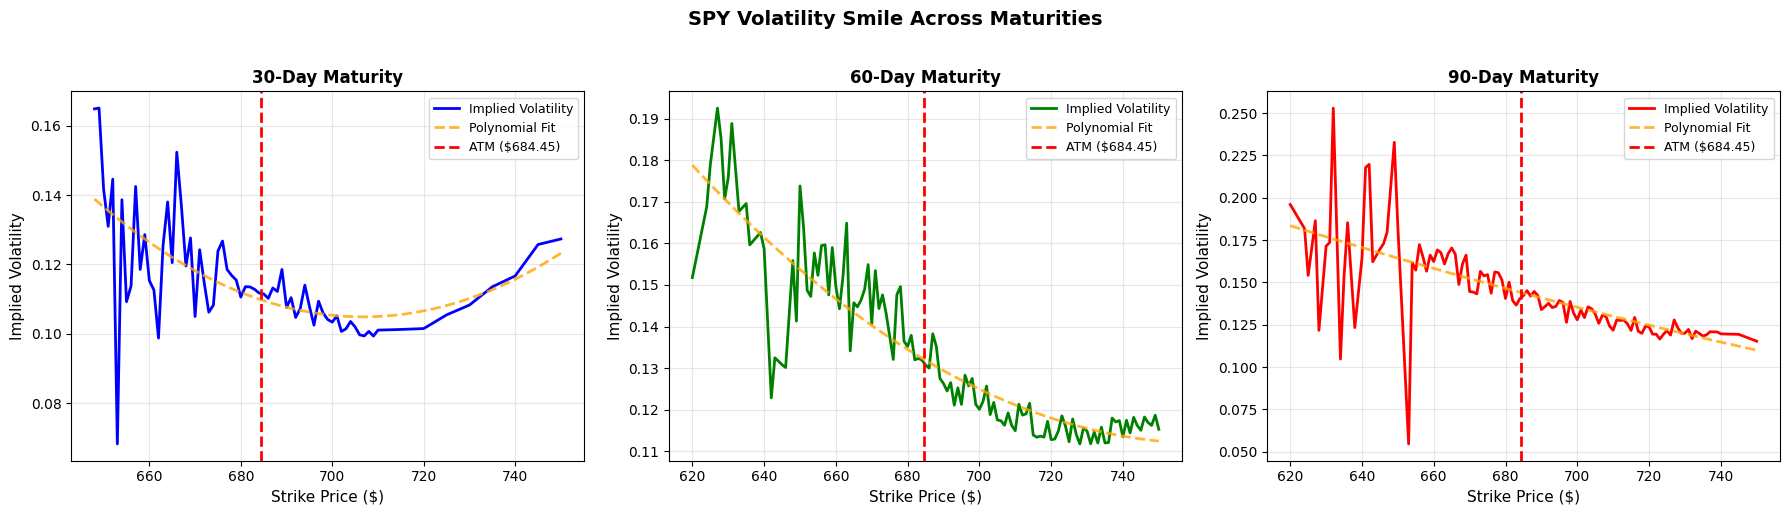

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {30: 'blue', 60: 'green', 90: 'red'}

for idx, target in enumerate([30, 60, 90]):
    data = all_calls_iv[target][['strike', 'calculated_iv']].dropna().sort_values('strike')
    
    # Polynomial fit to highlight the skew trend
    coeffs = np.polyfit(data['strike'], data['calculated_iv'], 2)
    poly_fit = np.poly1d(coeffs)
    strike_range = np.linspace(data['strike'].min(), data['strike'].max(), 200)
    iv_trend = poly_fit(strike_range)
    
    axes[idx].plot(data['strike'], data['calculated_iv'], '-', linewidth=2, 
                   color=colors[target], label='Implied Volatility')
    axes[idx].plot(strike_range, iv_trend, '--', linewidth=2, 
                   color='orange', alpha=0.8, label='Polynomial Fit')
    axes[idx].axvline(x=current_price, color='red', linestyle='--', linewidth=2, 
                      label=f'ATM (${current_price:.2f})')
    
    axes[idx].set_xlabel('Strike Price ($)', fontsize=11)
    axes[idx].set_ylabel('Implied Volatility', fontsize=11)
    axes[idx].set_title(f'{target}-Day Maturity', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(fontsize=9)

plt.suptitle('SPY Volatility Smile Across Maturities', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 4.3 Interpretation of Smile Evolution

**Key Observations:**

1. **Flattening Effect:** The volatility smile becomes progressively flatter as maturity increases from 30 to 90 days

2. **Economic Interpretation:**
   - **Short-term (30 days):** Pronounced skew reflects acute crash risk perception
   - **Medium-term (60 days):** Moderate skew as risk dilutes over time
   - **Long-term (90 days):** Flatter smile due to mean reversion expectations

3. **Mechanisms:**
   - **Mean reversion:** Volatility tends to revert to long-term averages
   - **Risk dilution:** Crash probability spreads over longer horizons
   - **Leverage effect:** Short-term options have higher gamma sensitivity



---

## 5. Volatility Surface Construction

### 5.1 3D Representation

The volatility surface provides a complete view of implied volatility as a function of both strike price and time to expiration. This three-dimensional representation is essential for:
- Pricing exotic options
- Risk management across the entire options book
- Identifying arbitrage opportunities

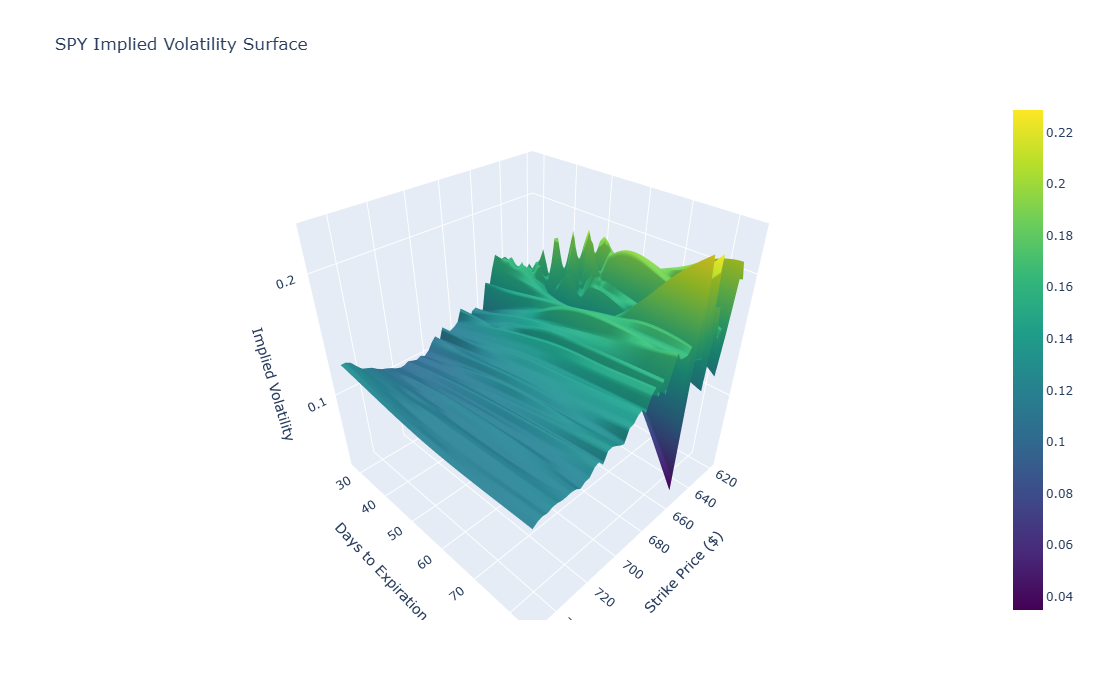

In [8]:
import plotly.graph_objects as go
from scipy.interpolate import griddata

# Combine all data
all_data = []
for target in [30, 60, 90]:
    data = all_calls_iv[target][['strike', 'calculated_iv']].copy()
    data['days'] = selected_expirations[target]['actual_days']
    all_data.append(data)

df_surface = pd.concat(all_data, ignore_index=True)

# Prepare grid for interpolation
strikes = df_surface['strike'].values
days = df_surface['days'].values
ivs = df_surface['calculated_iv'].values

strike_grid = np.linspace(strikes.min(), strikes.max(), 50)
days_grid = np.linspace(days.min(), days.max(), 50)
strike_mesh, days_mesh = np.meshgrid(strike_grid, days_grid)

# Interpolate
iv_mesh = griddata((strikes, days), ivs, (strike_mesh, days_mesh), method='cubic')

# Create interactive 3D surface
fig = go.Figure(data=[go.Surface(x=strike_mesh, y=days_mesh, z=iv_mesh, 
                                  colorscale='Viridis')])

fig.update_layout(
    title='SPY Implied Volatility Surface',
    scene=dict(
        xaxis_title='Strike Price ($)',
        yaxis_title='Days to Expiration',
        zaxis_title='Implied Volatility'
    ),
    width=900,
    height=700
)

fig.show()

### 5.2 Surface Characteristics

The volatility surface exhibits several notable features:

1. **Strike Dimension:** Clear skew with higher volatility for lower strikes (put wing)
2. **Time Dimension:** General increase in volatility with maturity
3. **Curvature:** Non-linear relationship reflecting market supply/demand dynamics
4. **Localized Spikes:** May indicate illiquid strikes or data artifacts

**Note on Spikes:** The observed volatility spikes can be attributed to:
- Low liquidity (wide bid-ask spreads)
- Cubic interpolation artifacts
- Stale or unreliable market prices

In production environments, additional filtering and smoothing techniques would be applied.

---

## 6. Greeks Analysis

### 6.1 Option Greeks: Sensitivity Measures

Greeks quantify how option prices change with respect to various parameters. They are essential for:
- **Portfolio hedging:** Neutralizing unwanted exposures
- **Risk management:** Understanding position sensitivities
- **Trading strategies:** Optimizing Greeks profile

### 6.2 Key Greeks Definitions

- **Delta (Δ):** Sensitivity to underlying price | $\frac{\partial C}{\partial S}$
- **Gamma (Γ):** Rate of Delta change | $\frac{\partial^2 C}{\partial S^2}$
- **Vega (ν):** Sensitivity to volatility | $\frac{\partial C}{\partial \sigma}$
- **Theta (Θ):** Time decay | $\frac{\partial C}{\partial t}$

In [9]:
def calculate_greeks(S, K, T, r, sigma):
    """
    Calculate option Greeks
    
    Returns: delta, gamma, vega, theta (per day)
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r*T) * norm.cdf(d2)
    
    return delta, gamma, vega, theta / 365

# Calculate Greeks for 60-day maturity
target = 60
T = selected_expirations[target]['T']
data = all_calls_iv[target].copy()

greeks_list = []
for _, row in data.iterrows():
    delta, gamma, vega, theta = calculate_greeks(
        current_price, row['strike'], T, r, row['calculated_iv']
    )
    greeks_list.append({
        'strike': row['strike'],
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta
    })

df_greeks = pd.DataFrame(greeks_list).sort_values('strike')

print("Greeks calculated successfully for 60-day maturity")
print(f"\nSample Greeks (first 5 strikes):")
print(df_greeks.head())

Greeks calculated successfully for 60-day maturity

Sample Greeks (first 5 strikes):
   strike     delta     gamma       vega     theta
0   620.0  0.964011  0.001943  21.194283 -0.095223
1   624.0  0.936613  0.002748  33.335489 -0.115001
2   625.0  0.922475  0.003027  38.918971 -0.125889
3   627.0  0.900390  0.003390  46.916289 -0.142820
4   628.0  0.904801  0.003408  45.382936 -0.137708


### 6.3 Greeks Visualization and Interpretation

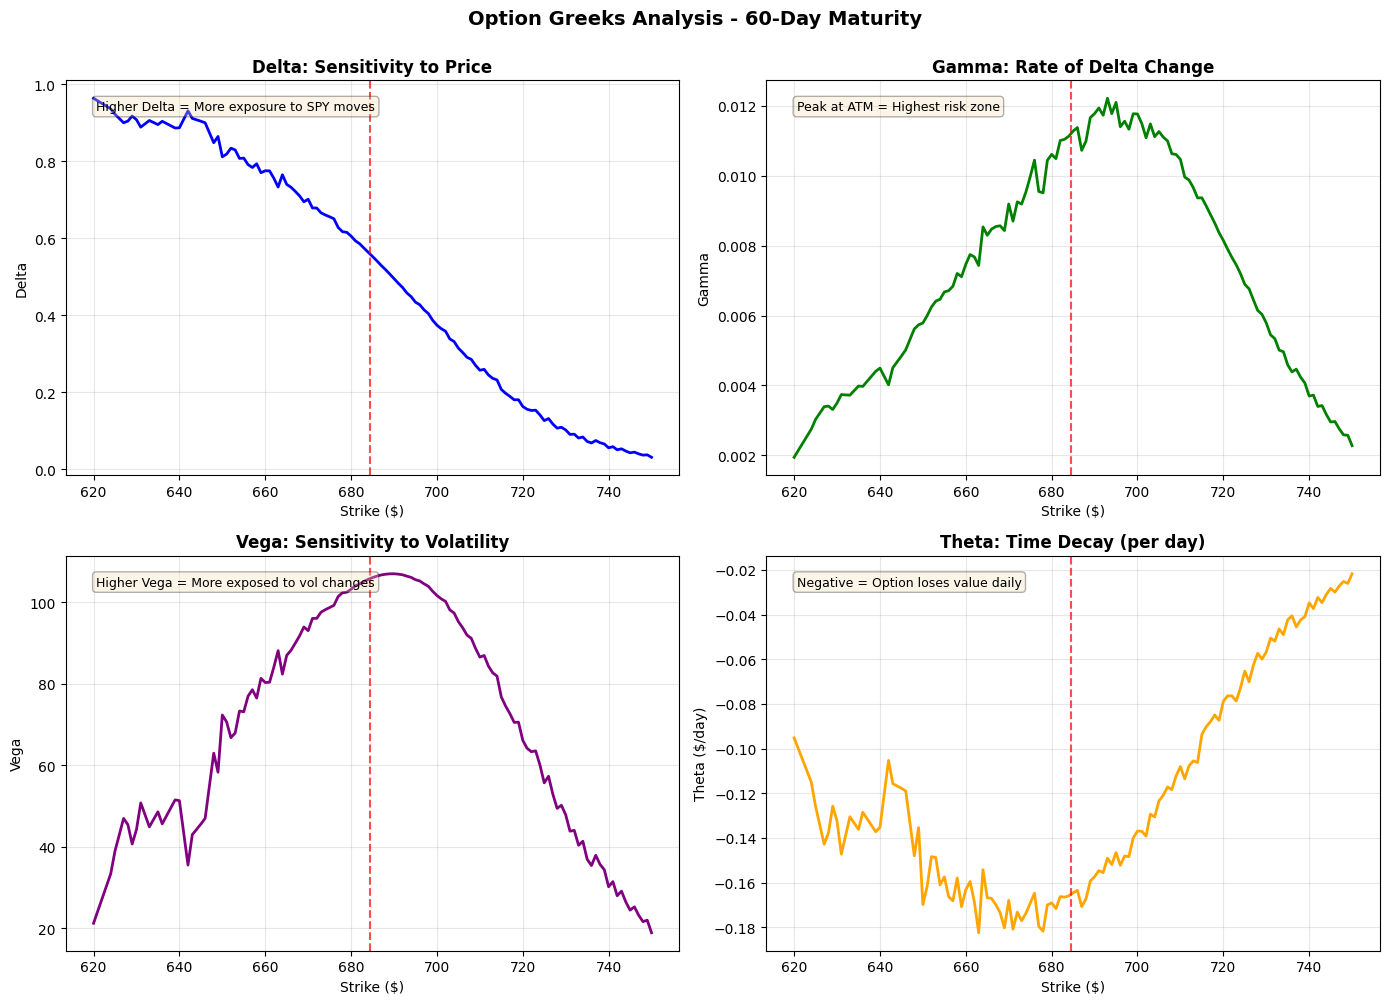

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Delta
axes[0, 0].plot(df_greeks['strike'], df_greeks['delta'], linewidth=2, color='blue')
axes[0, 0].axvline(x=current_price, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title('Delta: Sensitivity to Price', fontweight='bold')
axes[0, 0].set_xlabel('Strike ($)')
axes[0, 0].set_ylabel('Delta')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].text(0.05, 0.95, 'Higher Delta = More exposure to SPY moves', 
                transform=axes[0, 0].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Gamma
axes[0, 1].plot(df_greeks['strike'], df_greeks['gamma'], linewidth=2, color='green')
axes[0, 1].axvline(x=current_price, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_title('Gamma: Rate of Delta Change', fontweight='bold')
axes[0, 1].set_xlabel('Strike ($)')
axes[0, 1].set_ylabel('Gamma')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].text(0.05, 0.95, 'Peak at ATM = Highest risk zone', 
                transform=axes[0, 1].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Vega
axes[1, 0].plot(df_greeks['strike'], df_greeks['vega'], linewidth=2, color='purple')
axes[1, 0].axvline(x=current_price, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_title('Vega: Sensitivity to Volatility', fontweight='bold')
axes[1, 0].set_xlabel('Strike ($)')
axes[1, 0].set_ylabel('Vega')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].text(0.05, 0.95, 'Higher Vega = More exposed to vol changes', 
                transform=axes[1, 0].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Theta
axes[1, 1].plot(df_greeks['strike'], df_greeks['theta'], linewidth=2, color='orange')
axes[1, 1].axvline(x=current_price, color='red', linestyle='--', alpha=0.7)
axes[1, 1].set_title('Theta: Time Decay (per day)', fontweight='bold')
axes[1, 1].set_xlabel('Strike ($)')
axes[1, 1].set_ylabel('Theta ($/day)')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].text(0.05, 0.95, 'Negative = Option loses value daily', 
                transform=axes[1, 1].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Option Greeks Analysis - 60-Day Maturity', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 6.4 Greeks Interpretation

**Delta Pattern:**
- Increases from 0 (deep OTM) to 1 (deep ITM)
- ATM options have Delta ≈ 0.5
- Steepest slope near ATM indicates high sensitivity

**Gamma Peak:**
- Maximum at ATM strikes
- Indicates highest delta-hedging frequency required
- Represents the "danger zone" for market makers

**Vega Distribution:**
- Highest for ATM options
- Shows which options benefit most from volatility increases
- Critical for volatility trading strategies

**Theta (Time Decay):**
- Most negative for ATM options
- Options lose value as expiration approaches
- Key consideration for option sellers

---

## 7. Conclusions

### 7.1 Key Findings

This analysis successfully demonstrates:

1. **Volatility Smile Existence:** Market prices systematically deviate from Black-Scholes constant volatility assumption

2. **Term Structure Effects:** The smile flattens with increasing maturity, consistent with:
   - Mean reversion in volatility
   - Risk dilution over time

3. **Complete Surface Construction:** Successfully built an interactive 3D volatility surface enabling:
   - Consistent pricing across all strikes and maturities
   - Risk assessment for complex portfolios
   - Arbitrage detection capabilities

4. **Greeks Patterns:** Quantified sensitivities reveal optimal hedging and risk management strategies

### 7.2 Limitations

**Current Limitations:**
- Limited to 3 maturities (could extend to 5-7 for smoother surface)
- No dividend yield consideration (affects deep ITM options)
- Cubic interpolation may create artifacts
- American options not addressed





---

## References

1. Black, F., & Scholes, M. (1973). "The Pricing of Options and Corporate Liabilities." *Journal of Political Economy*, 81(3), 637-654.

2. Hull, J. C. (2018). *Options, Futures, and Other Derivatives* (10th ed.). Pearson.

3. Gatheral, J. (2006). *The Volatility Surface: A Practitioner's Guide*. Wiley Finance.

4. Rebonato, R. (2004). *Volatility and Correlation: The Perfect Hedger and the Fox* (2nd ed.). Wiley.

5. Yahoo Finance API via yfinance Python library

---

**Author Contact:**  
Louison Robert  
Master 1 Finance, Université Paris-Saclay  
[louison-robert@outlook.fr]